# WCC Exposure Time Calculator Tool

This jupyter notebook let's user test WCC observations and get SNR/exposure time calculations.

This uses `ExposureTimeSNRCalculator.py`. This notebook runs the minimum functionality of the ETC and runs the default STP configurations using the refactored `config_stp` and `config_stp_wcc` repos.

### Creating Synthetic Astrophysical Observations

In order to accurately recreate observed results, we need to recreate the conditions that are typical of such observations.

When considering all electromagnetic effects that go into an observation we need to first consider the background environment of the source. The background will have an associated spectra (usually the CMB background, the extragalactic background, etc.)

After the background spectra is considered, we can then consider the source spectra. We can approximate a source spectra to differing levels of complexity as required. From simplest to more complex, we can create flat spectra, black body approximations, or import simulated/observed spectra from spectral libraries available online. All these spectra can then be manipulated to simulate placement at different distances, apparent velocities (redshifting/blueshifting), etc.

From here, we need to consider any effects due to the intergalactic/interstellar medium and other external spectral factors. We can add emission and absorption features as well as broad extinction features.

Once we have our observational parameters set up, we need only consider effects from hardware.

To do this, we can "build" an observatory, including information such as it primary mirror diameter, mirror material, number of mirrors, the focal length, and we can add on a CCD and include its properties (gain, dark current, etc.) as well.

NOTE: There is a pre-built version of the WCC available that uses the latest hardware and design specifications on file (from the `stp_reference_data` sub-repo)

We can do all this utilizing the Synphot package developed by STSci (https://synphot.readthedocs.io/en/latest/)

# SNR Calculation Background
### SNR for a given Exposure Time

Signal-to-Noise Ratio
$$
SNR = \frac{S_{source}}{N_{total}}
$$
where $S_{source}$ is the source signal and $N_{total}$ is the total signal noise.

For independent noise sources, the total noise is the sum of the individual noise variances $N_{total}^2 = \sigma_{total}^2 = \sum_i^n \sigma_i^2$.

Noise can come from:
1. Target Source: $S_{source} = \sigma_{source}^2$
2. Sky Background: $S_{sky} = \sigma_{sky}^2$
3. Thermally Excited Electrons (Dark Current): $S_{dark \; current} = \sigma_{dark \; current}^2$
4. Readout Noise: $R^2 = \sigma_{readout}^2$

So
$$
N_{total} = \sqrt{ \sigma_{source}^2 + \sigma_{sky}^2 + \sigma_{dark \; current}^2 + \sigma_{readout}^2 }
$$

Thus
$$
SNR = \frac{\sigma_{source}^2}{\sqrt{ \sigma_{source}^2 + \sigma_{sky}^2 + \sigma_{dark \; current}^2 + \sigma_{readout}^2 }}
$$

When observations are made, each of the following are recorded by the CCD the corresponding units (usually):
1. Target Source: $S_{source}$ in [$e^{-} \; s^{-1}$] 
2. Sky Background: $S_{sky}$ in [$e^{-} \; s^{-1} \; pixel^{-1}$] 
3. Thermally Excited Electrons (Dark Current): $S_{dark \; current}$ [$e^{-} \; s^{-1} \; pixel^{-1}$]
4. Readout Noise: $R^2$ [$e^{-} \; pixel^{-1}$]

If $S_{source}$ and $S_{sky}$ are in electron units, after converting from photon units using the CCD's Quantum Efficiency coefficient Q (which ranges from 0 to 1), and multiplying by exposure time t. The resulting SNR equantion is a follows:
$$
SNR = \frac{ S_{source} t }{ \sqrt{ S_{source} t + S_{sky} t + S_{dark \; current} t n_{psfpixels} + R^2 n_{psfpixels} n_{frames} } }
$$

The implementation of the other functions in the ETC is based on the expressions calculated from the previous expression. These are described in greater detail next.

### Exposure Time for a given SNR

From the above equation for SNR, we can solve for exposure time as a function of SNR. 

From there get the following quadratic equation:
$$
t^2 - \left[ \frac{(SNR)^2}{S_{source}^2} \left(S_{source} + S_{sky} + S_{dark \; current} n_p\right) \right] t - \left(\frac{(SNR)^2}{S_{source}^2}\right) R^2 n_p \frac{t}{t_{exp}} = 0
$$
Letting 
$$\left(\frac{S_{source}}{(SNR)}\right)^2 = A$$
$$- \left(S_{source} + S_{sky} + S_{dark \; current} n_p - \frac{R^2 n_p}{t_{exp}}\right) = B$$
we get the solution:
$$
t = \frac{|B|}{A}
$$

### Source Counts Required for a given SNR and Exposure Time

From the SNR equation, we can solve for Source counts as a function of exposure time and SNR to get the following quadratic equation:

$$
S_{source}^2 t^2 - S_{source} (SNR)^2 t - S_{sky} (SNR)^2 t  - (SNR)^2 n_{psfpixels} (S_{dark \; current} t + R^2 \frac{t}{t_{exp}}) = 0
$$

Let

$$
A = t/SNR^2
$$

$$
B = - 1
$$

$$
C = - S_{sky} - n_{psfpixels} \left( S_{dark \; current} + \frac{R^2}{t_{exp}} \right)
$$

So

$$
S_{source} = \frac{ -B + \sqrt{ B^2 - 4 A C } } {2 A}
$$

Where the negative solution is ignored. 

### Workflow for using the ETC

There are 3 function calls that set up the ETC and 1 to call the actual SNR calculation. In order, these are `make_STP`, `set_source`, `set_background` and `make_observation`. We call each of these in turn. 

First, the `make_STP` function initializes the default `.toml` files from the `config_stp` and `config_stp_wcc`. 

In [1]:
import config_stp_wcc
import config_um

data_stp = config_um.load_config_values()
data_path_stp = config_um.get_data_path()
data_path_stp = data_path_stp if data_path_stp.endswith('/') else data_path_stp + '/'

data_path_wcc = config_stp_wcc.get_data_path()
data_wcc = config_stp_wcc.load_config_values()
print(data_stp)
print("*********************************************************************************************************")
print(data_wcc)
print("*********************************************************************************************************")
print("Data path:")
print(data_path_stp)
print(data_path_wcc)
print("*********************************************************************************************************")

from utils_config.version_check import check_imports_and_versions

# Argument output_file='Test_table.mrt' can be provided to print to file
check_imports_and_versions(globals().items()) 



filter_path = data_wcc['WCC_ETC']['filters']['filter']
prepend_if_not_none = lambda s1, s2: f"{s1}{s2}" if s1 is not None else s2
f_path = prepend_if_not_none(data_path_wcc, filter_path)
# print(data_stp['astrophysics']['sources']['supernova_templates'])

{'telescope': {'title': 'Ultramarine Telescope Baseline Configuration', 'general': {'f_number': 15.0, 'f_eff': '42.047m', 'version': 'UM Mark 10', 'field_bias': '0.2degree', 'design_wavelength': '633.0nm'}, 'optics': {'m1': {'aper_clear_OD': '3.065m', 'aper_clear_ID': '0.0m', 'surface_rms': '21e-9m', 'surface_rms_goal': '9.4e-9m', 'opd_map': '/home/ssabhlok/Documents/UASAL/uasal_archive/projects/um/mirror_data/opd_maps/M1_map.fits', 'opd_map_goal': '/home/ssabhlok/Documents/UASAL/uasal_archive/projects/um/mirror_data/opd_maps/M1_goal_map.fits', 'temp_nominal': '22Celsius', 'temp_nominal_delta': '0.5Kelvin', 'temp_stability': '0.1Kelvin/hour', 'coating_refl': 'coatings/NIST_1st_surface_Al.csv', 'coating_refl_rms': 0.02}, 'm2': {'aper_clear_OD': '0.220m', 'aper_clear_ID': '0.0m', 'surface_rms': '8e-9m', 'psd_b': 10, 'psd_c': 2.65, 'opd_map': '/home/ssabhlok/Documents/UASAL/uasal_archive/projects/um/mirror_data/opd_maps/M2_map.fits', 'temp_nominal': '-6Celsius', 'temp_nominal_delta': '11K

Adding Sensor
Adding Mirrors
Adding Filters


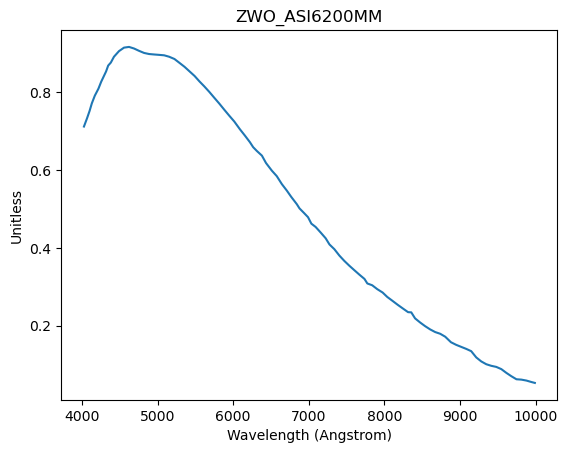

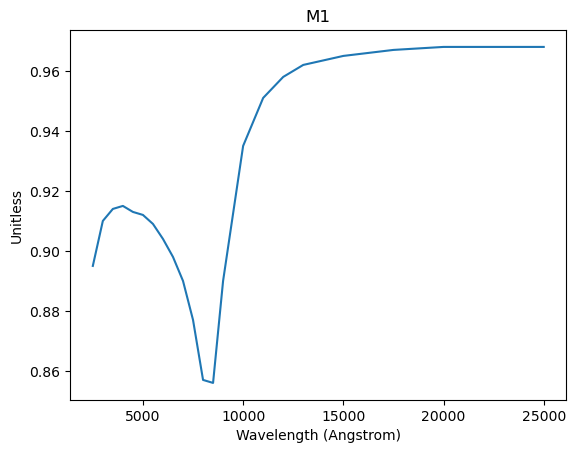

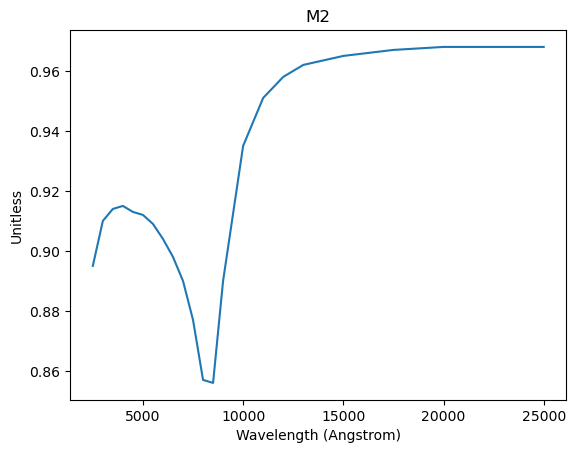

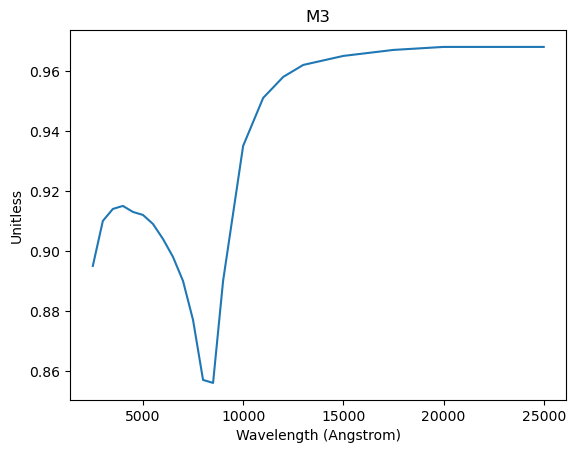

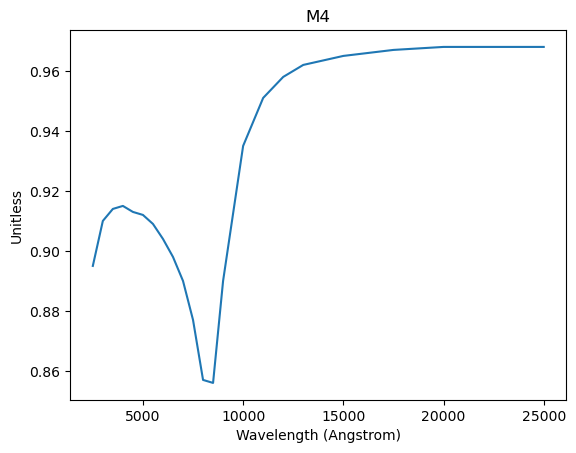

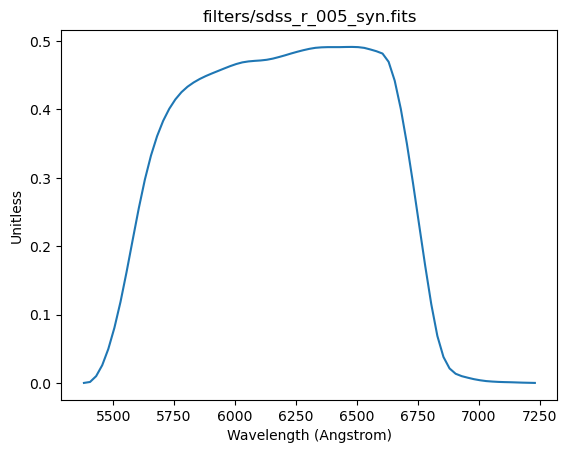

In [2]:
from astropy import units as u
import os

# Get the path to the environment variable UASAL_ARCHIVE
uasal_archive = os.environ.get("UASAL_ARCHIVE")

from stp_etc_imaging import ExposureTimeSNRCalculator as etsc
obs = etsc.Observatory(telescope_name="UM")
obs.make_STP(plot=True)

Then, we initialize the source, providing the support_data path. There are two kinds of sources available right now. The first option is to pick a spectrum from the set of pickles files, taken from the [Pickles Atlas](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/pickles-atlas).


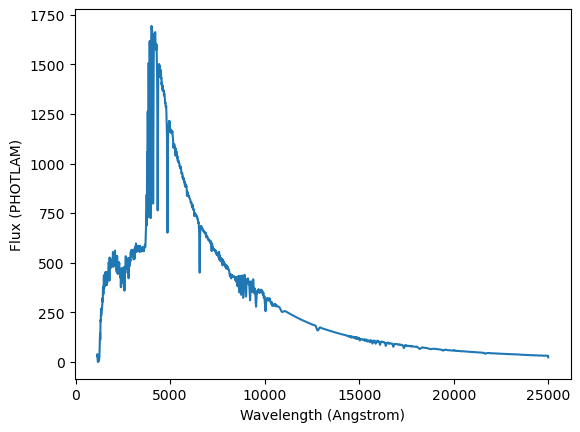

In [3]:
obs.set_source(source_pickles_file='pickles_uk_9.fits', 
               support_data_path=f'{uasal_archive}/astr_obj_models/stars/pickles_models/dat_uvk/', 
               plot=True)

The second option is to pick a spectrum from the Supernova templates. These are taken from the [SALTShaker Repo](https://saltshaker.readthedocs.io/en/latest/), and specifically the [Hsiao 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...663.1187H/abstract) paper.

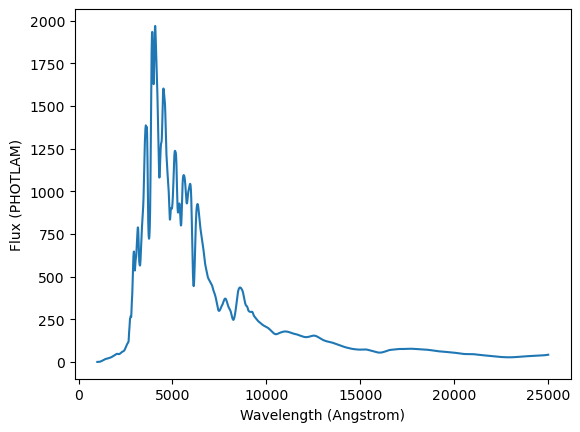

In [4]:
obs.create_supernova_spectrum(epoch=1, source_z=0.0, plot=True, support_data_path=data_path_stp)

Running either command will overwrite the source in the `obs` object. 

We now initialize the background. Since this is defined in `config_stp` we will call that here for demonstration. 

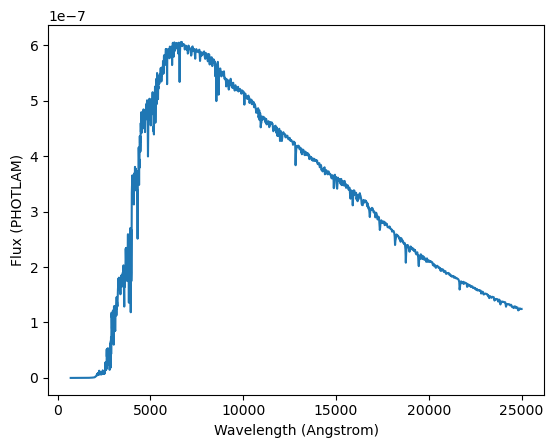

In [5]:
obs.set_background(background_file=data_stp['astrophysics']['zodi']['profile'], support_data_path=data_path_stp, plot=True)

Now we construct an observation. The source flux is in magnitudes, but the background flux MUST BE provided in Surface Brightness units (mag/arcsec**2)

(<Quantity 162.30700376 electron / s>, <Quantity 19.93650899 electron / s>)

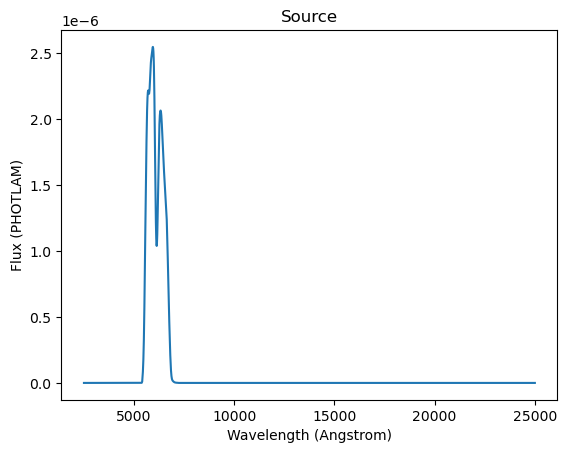

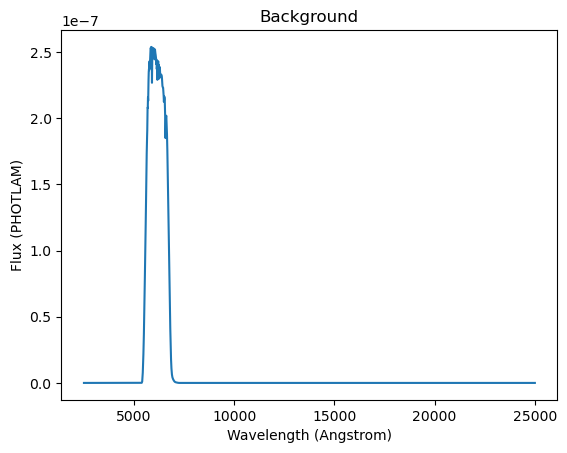

In [6]:
obs.make_observation(flux=20, flux_units='AB', bg_flux=22.5, bg_flux_units=u.ABmag, plot=True)

This can now be used to compute quantities of interest. 

In [7]:
obs.calc_saturation_time()

<Quantity 3214.91531205 s>

We can calculate the SNR for a given time (in seconds) using `[observatory].calc_SNR(exp_time)`

In [8]:
obs.calc_SNR(int_time=3600.*u.s, exp_time=100*u.s)

np.float64(717.4636861017276)

We can also calculate the integration time required for a given SNR and exposure time using `[observatory].calc_int_time(req_SNR, exp_time)`

In [9]:
obs.calc_int_time(140, exp_time=1.0*u.s)

<Quantity 198.51229265 s>

And finally, we can check what source flux is required for given SNR, integration time and exposure time. 

In [10]:
obs.calc_req_source(snr=10, int_time=1000.0*u.s,exp_time=10*u.s)

np.float64(1.0363920994547726)

Or if the desired units are in magnitudes.

In [11]:
obs.calc_req_source(snr=10, int_time=1000.0*u.s,exp_time=10*u.s, magnitude=True)

(25.487032917389115,
 ['/home/ssabhlok/anaconda3/envs/lina/lib/python3.12/site-packages/config_stp_wcc/support_data/filters/sdss_r_005_syn.fits x 1'])